In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/train.csv')
data.head()

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   
2     520    shsy5y  11h30m00s  2019-06-16   
3     520    shsy5y  11h30m00s  2019-06-16   
4     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


Mask annotations are stored as a run length encoded image masks as a string data type. The way that these annotations are stored are useful for compression but need to be converted into bounding box coordinates. This is a common utility function required for working with kaggle datasets

In [4]:
def run_length_encoder_to_mask(runlength, img_w, img_h):
    #transform the string into an array
    array = np.fromiter(runlength.split(), dtype = np.uint)
    array = array.reshape((-1,2)).T
    array[0] = array[0]-1
    #decompress the run length encoding
    starts, lengths = array
    mask_decompressed = np.concatenate([np.arange(s,s+1, dtype = np.uint) for s,l in zip(starts,lengths)])
    #building the binary mask
    mask_img = np.zeros(img_w * img_h, dtype = np.uint8)
    mask_img[mask_decompressed] = 1
    mask_img = mask_img.reshape((img_h, img_w))
    mask_img = np.asfortranarray(mask_img)
    return mask_img

## Minor Sanity Check 
Check that the run length encoding can be extracted from the csv table and that the segmentation mask can be generated

In [5]:
run_length = data.loc[0, 'annotation']
print(run_length)

118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4


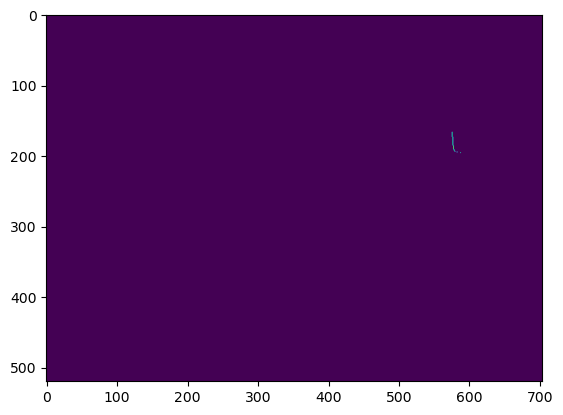

In [6]:
plt.imshow(run_length_encoder_to_mask(run_length, 704,520))

In [8]:
from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
from joblib import Parallel, delayed

def annotate(idx, row, cat_ids):
    #decode rle into binary mask
    mask = run_length_encoder_to_mask(row['annotation'], row['width'],row['height'])
    #encode back to coco rle 
    c_rle = maskUtils.encode(mask)
    #convert from brinary to utf-8
    c_rle['counts'] = c_rle['counts'].decode('utf-8')
    #calculate area and bbox from run length encoding
    area = maskUtils.area(c_rle).item()
    bbox = maskUtils.toBbox(c_rle).astype(int).tolist()
    annotation = {
        'segmentation': c_rle,
            'bbox': bbox,
            'area': area,
            'image_id':row['id'], 
            'category_id':cat_ids[row['cell_type']], 
            'iscrowd':0, 
            'id':idx
    }
    return annotation



In [11]:
def coco_structure(dataframe, workers=4):
     ## Building the header
    cat_ids = {name:id+1 for id, name in enumerate(dataframe.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in dataframe.groupby('id').agg('first').iterrows()]
    
    ## Building the annotations
    annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(dataframe.iterrows(), total = len(dataframe)))
        
    return {'categories':cats, 'images':images, 'annotations':annotations}


In [12]:
import json,itertools
root = coco_structure(data)

  0%|          | 0/73585 [00:00<?, ?it/s]

In [13]:
root['annotations'][0]

{'segmentation': {'size': [520, 704], 'counts': 'WeT97X`050J0L0O`P10`P10cUh1'},
 'bbox': [576, 167, 13, 30],
 'area': 30,
 'image_id': '0030fd0e6378',
 'category_id': 1,
 'iscrowd': 0,
 'id': 0}

In [14]:
with open('annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

## Sanity Check

Double check that the annotations can be read from generated JSON containing the annotations

In [25]:
from pycocotools.coco import COCO
from pathlib import Path
from PIL import Image

dataDir=Path('data')
annFile = Path('annotations_train.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


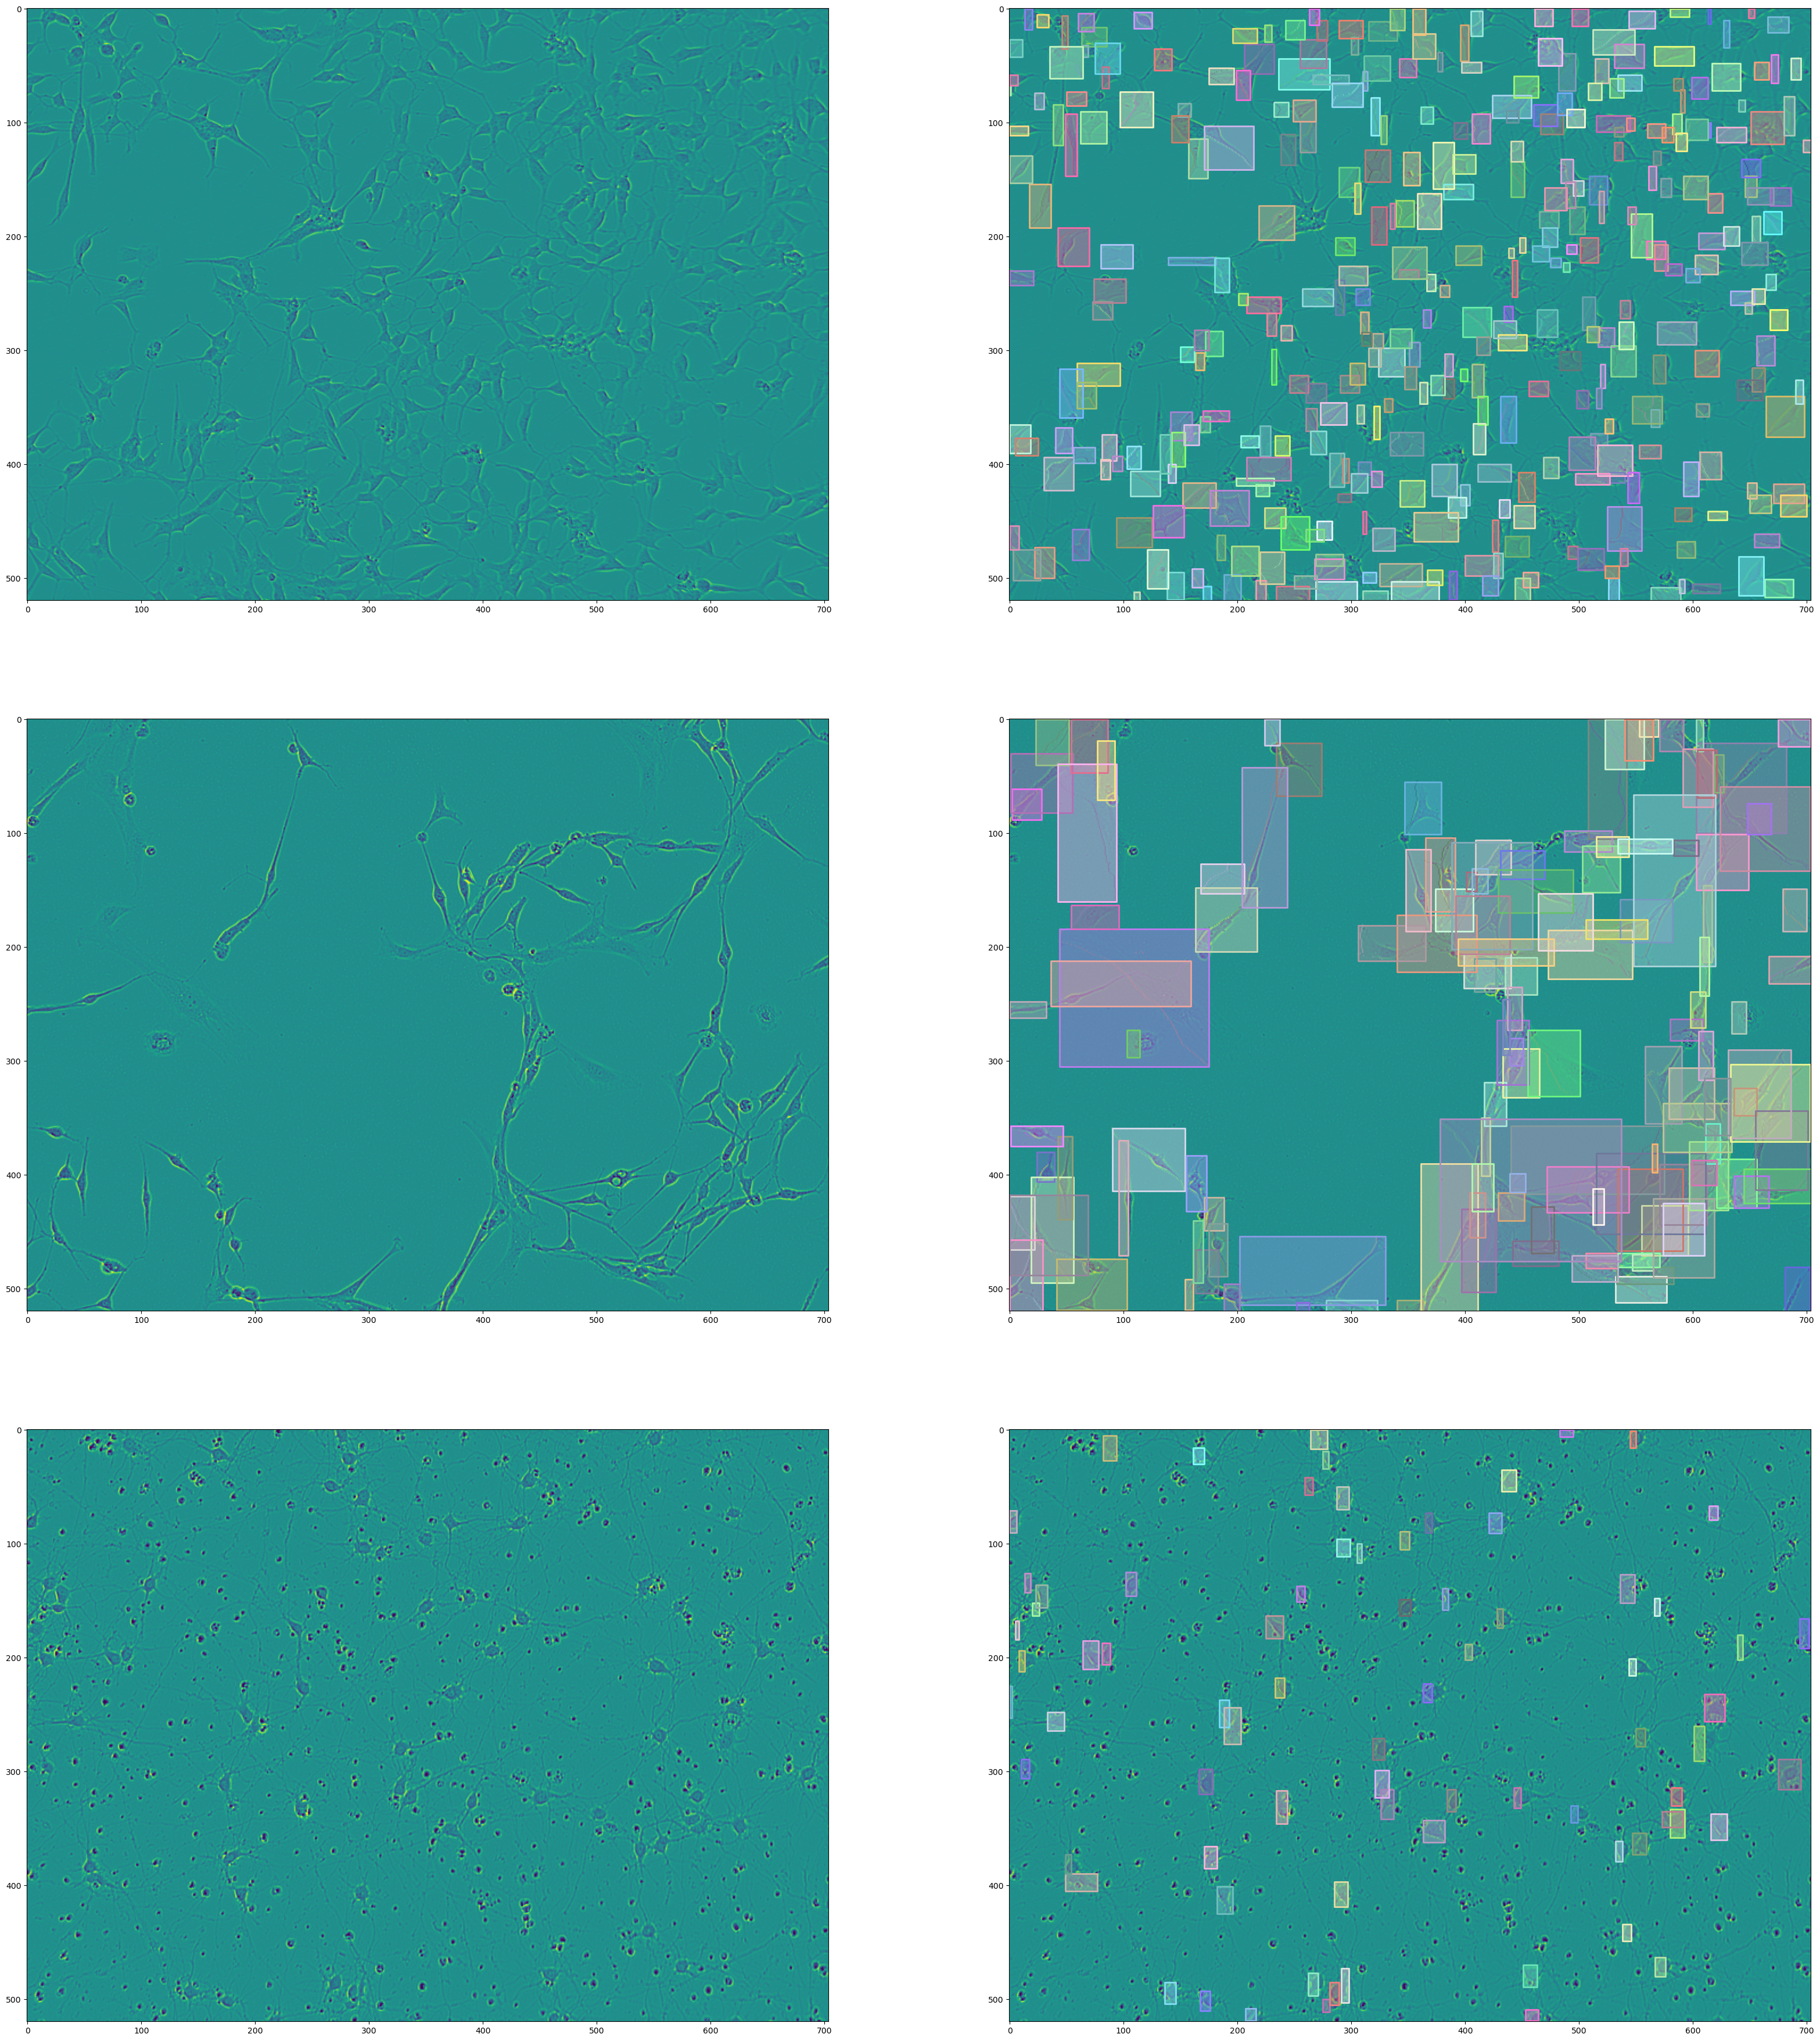

In [35]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.open(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)